In [23]:
%matplotlib inline

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

import seaborn as sns

In [82]:
!sbt "run-main ZeroIntelligenceApp"

[info] Loading global plugins from /Users/drpugh/.sbt/0.13/plugins
[info] Loading project definition from /Users/drpugh/Research/scalabm/models-library/gode-sunder/project
[info] Set current project to gode-sunder-model (in build file:/Users/drpugh/Research/scalabm/models-library/gode-sunder/)
[info] Running ZeroIntelligenceApp 
[info] -XX:InitialHeapSize=3226678064 -XX:MaxHeapSize=6442450944 -XX:MaxNewSize=3221225472 -XX:NewSize=3221225472 -XX:+PrintCommandLineFlags -XX:-UseBiasedLocking -XX:+UseCompressedClassPointers -XX:+UseCompressedOops -XX:+UseCondCardMark -XX:+UseNUMA -XX:+UseParallelGC 
[success] Total time: 8 s, completed Mar 23, 2016 5:29:47 PM


## Importing the raw data

In [83]:
# this is a bit of a hack as current log files are not valid JSON!
with open('./data/fills.log') as data_file:    
    zi_data = pd.read_json('[%s]' % ','.join(data_file.read().splitlines()))
    zi_data.set_index('timestamp', inplace=True)

In [84]:
zi_data.head()

,askPrice,bidPrice,class,price,quantity,tradable
timestamp,,,,,,
2016-03-23 17:29:41.440,3,79,markets.Fill,3,1,Gpi2
2016-03-23 17:29:41.461,54,92,markets.Fill,92,1,Gpi2
2016-03-23 17:29:41.461,25,67,markets.Fill,67,1,Gpi2
2016-03-23 17:29:41.461,74,188,markets.Fill,74,1,Gpi2
2016-03-23 17:29:41.462,33,59,markets.Fill,59,1,Gpi2


In [85]:
zi_data.tail()

,askPrice,bidPrice,class,price,quantity,tradable
timestamp,,,,,,
2016-03-23 17:29:46.841,76,167,markets.Fill,76,1,Gpi2
2016-03-23 17:29:46.841,21,76,markets.Fill,76,1,Gpi2
2016-03-23 17:29:46.841,110,191,markets.Fill,110,1,Gpi2
2016-03-23 17:29:46.841,120,186,markets.Fill,120,1,Gpi2
2016-03-23 17:29:46.841,48,91,markets.Fill,91,1,Gpi2


In [86]:
zi_data.describe()

,askPrice,bidPrice,price,quantity
count,76652.000000,76652.000000,76652.000000,76652
mean,78.084955,122.060390,99.910387,1
std,45.064930,45.265237,31.190858,0
min,1.000000,25.000000,3.000000,1
25%,39.000000,83.000000,74.000000,1
50%,78.000000,122.500000,100.000000,1
75%,117.000000,161.000000,126.000000,1
max,158.000000,199.000000,164.000000,1


### Compute the bid-ask spread...

    spread = bidPrice - askPice

In [87]:
zi_data['spread'] = zi_data.bidPrice - zi_data.askPrice

In [88]:
zi_data.spread.describe()

count    76652.000000
mean        43.975434
std         29.906473
min          1.000000
25%         20.000000
50%         39.000000
75%         63.000000
max        155.000000
Name: spread, dtype: float64

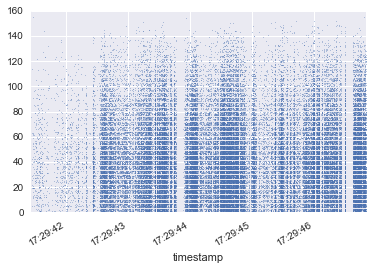

In [89]:
zi_data.spread.plot(linestyle='none', marker='o', markersize=1, alpha=0.5)
plt.show()

<h2> Compute raw returns </h2>

$$ r_{t+k} = \frac{p_{t+k} - p_{t}}{p_{t}} = \frac{\Delta p_{t+k}}{p_{t}}$$ 

Note that raw returns are bounded below! Bounds on price (at least in these simulations!) are $1 \le p_t \le 200$. Therefore lower bound on raw returns is...

$$ \underline{r} = \frac{1 - 200}{200} \approx -1. $$

Similarly, then upper bound on raw returns is...

$$ \underline{r} = \frac{200 - 1}{1} = 199. $$


In [90]:
zi_data['raw_returns'] = zi_data.price.pct_change(periods=1)

In [91]:
zi_data.raw_returns.describe()

count    76651.000000
mean         0.109779
std          0.544210
min         -0.730769
25%         -0.241379
50%          0.000000
75%          0.313725
max         29.666667
Name: raw_returns, dtype: float64

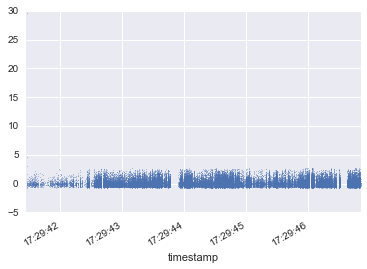

In [92]:
zi_data.raw_returns.plot(linestyle='none', marker='o', markersize=1, alpha=0.5)
plt.show()

## Compute logarithmic returns

Starting from raw returns, $r_{t+k}$ we see that...

$$ 1 + r_{t+k} = 1 + \frac{p_{t+k} - p_t}{p_t} = \frac{p_{t+k}}{p_t} $$

...taking logs yields...

$$ \ln \big(1 + r_{t+k}\big) = \ln p_{t+k} - \ln p_t = \Delta \ln p_{t+k} $$

...since $\ln \big(1 + r_{t+k}\big) \approx r_{t+k}$ for $r << 1$ we should expect that raw and logarithmic return formulas should yields similar results for "small" returns.


In [93]:
zi_data['log_returns'] = np.log(1 + zi_data.raw_returns)

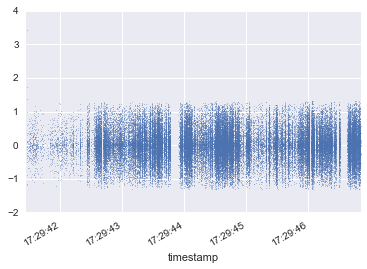

In [94]:
zi_data.log_returns.plot(linestyle='none', marker='o', markersize=1, alpha=0.5)
plt.show()

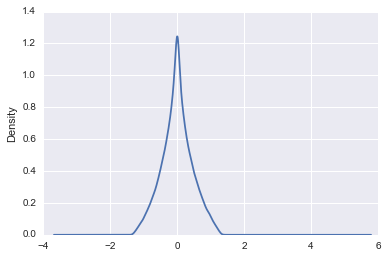

In [95]:
zi_data.log_returns.dropna().plot(kind='kde')
plt.show()

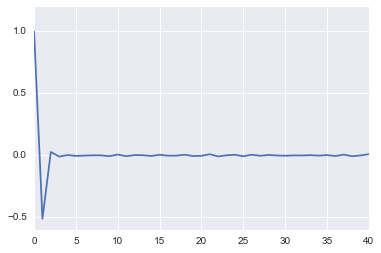

In [96]:
plt.plot(sm.tsa.acf(zi_data.log_returns.dropna(), fft=True))
plt.show()

<h3> Price impact </h3>

In [97]:
zi_data['mid_price'] = 0.5 * (zi_data.askPrice + zi_data.bidPrice)

How to best measure effective size? Particularly of ask orders!

In [98]:
zi_data['effective_size'] = zi_data.quantity

incoming_ask_orders = zi_data.bidPrice == zi_data.price
zi_data.loc[incoming_ask_orders, 'effective_size'] *= -zi_data.loc[incoming_ask_orders, 'askPrice']

incoming_bid_orders = zi_data.askPrice == zi_data.price
zi_data.loc[incoming_bid_orders, 'effective_size'] *= zi_data.loc[incoming_bid_orders, 'bidPrice']

Compute the measure of price impact: $\Delta \ln$ `mid_price`...

In [99]:
zi_data['price_impact'] = np.log(zi_data.mid_price).diff()

In [100]:
zi_data[incoming_ask_orders].head()

,askPrice,bidPrice,class,price,quantity,tradable,spread,raw_returns,log_returns,mid_price,effective_size,price_impact
timestamp,,,,,,,,,,,,
2016-03-23 17:29:41.461,54,92,markets.Fill,92,1,Gpi2,38,29.666667,3.423176,73.0,-54,0.576887
2016-03-23 17:29:41.461,25,67,markets.Fill,67,1,Gpi2,42,-0.271739,-0.317096,46.0,-25,-0.461818
2016-03-23 17:29:41.462,33,59,markets.Fill,59,1,Gpi2,26,-0.202703,-0.226528,46.0,-33,-1.046556
2016-03-23 17:29:41.462,15,44,markets.Fill,44,1,Gpi2,29,-0.588785,-0.888639,29.5,-15,-1.373501
2016-03-23 17:29:41.462,36,41,markets.Fill,41,1,Gpi2,5,-0.684615,-1.153962,38.5,-36,-1.433847


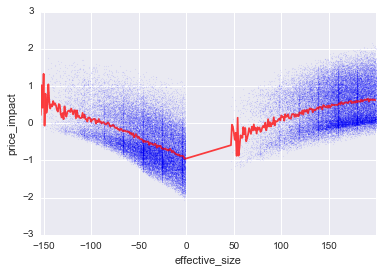

In [101]:
# incoming bid orders
fig, ax = plt.subplots(1, 1)
grouped_data = zi_data.groupby("effective_size")
grouped_data.price_impact.mean().plot(color='r', alpha=0.75, ax=ax)
ax.scatter(zi_data.effective_size, zi_data.price_impact, edgecolor='b', s=1, alpha=0.05)
ax.set_ylabel("price_impact")
plt.show()

## Cumulative distributions

In [102]:
ecdfs = {} 
for column_name in ['raw_returns', 'log_returns']:
    ecdfs[column_name] = sm.distributions.ECDF(zi_data[column_name].abs())

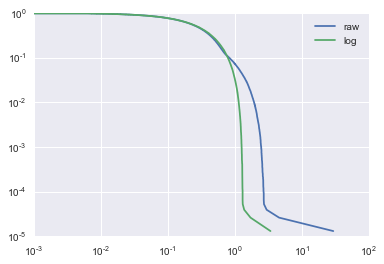

In [103]:
plt.plot(ecdfs['raw_returns'].x, 1 - ecdfs['raw_returns'].y, label='raw')
plt.plot(ecdfs['log_returns'].x, 1 - ecdfs['log_returns'].y, label='log')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

<h3> Zero Intelligence Constrained </h3>

In [118]:
!sbt "run-main ZeroIntelligenceConstrainedApp"

[info] Loading global plugins from /Users/drpugh/.sbt/0.13/plugins
[info] Loading project definition from /Users/drpugh/Research/scalabm/models-library/gode-sunder/project
[info] Set current project to gode-sunder-model (in build file:/Users/drpugh/Research/scalabm/models-library/gode-sunder/)
[info] Compiling 1 Scala source to /Users/drpugh/Research/scalabm/models-library/gode-sunder/target/scala-2.11/classes...
[info] Running ZeroIntelligenceConstrainedApp 
[info] -XX:InitialHeapSize=3226678064 -XX:MaxHeapSize=6442450944 -XX:MaxNewSize=3221225472 -XX:NewSize=3221225472 -XX:+PrintCommandLineFlags -XX:-UseBiasedLocking -XX:+UseCompressedClassPointers -XX:+UseCompressedOops -XX:+UseCondCardMark -XX:+UseNUMA -XX:+UseParallelGC 
[success] Total time: 11 s, completed Mar 24, 2016 6:26:37 AM


In [119]:
# this is a bit of a hack as current log files are not valid JSON!
with open('./data/fills.log') as data_file:    
    zic_data = pd.read_json('[%s]' % ','.join(data_file.read().splitlines()))
    zic_data.set_index('timestamp', inplace=True)

In [120]:
zic_data.describe()

,askPrice,bidPrice,price,quantity
count,35654.000000,35654.000000,35654.000000,35654
mean,84.642340,115.294245,101.269339,1
std,30.564718,28.320973,14.910021,0
min,0.000000,71.000000,71.000000,1
25%,63.000000,92.000000,89.000000,1
50%,90.000000,111.000000,101.000000,1
75%,110.000000,135.000000,114.000000,1
max,135.000000,198.000000,149.000000,1


In [121]:
zic_data['spread'] = zic_data.bidPrice - zic_data.askPrice
zic_data['raw_returns'] = zic_data.price.pct_change(periods=1)
zic_data['log_returns'] = np.log(1 + zic_data.raw_returns)

In [122]:
zi_data.spread.describe()

count    76652.000000
mean        43.975434
std         29.906473
min          1.000000
25%         20.000000
50%         39.000000
75%         63.000000
max        155.000000
Name: spread, dtype: float64

In [123]:
zic_data.spread.describe()

count    35654.000000
mean        30.651904
std         22.446934
min          1.000000
25%         12.000000
50%         26.000000
75%         45.000000
max        126.000000
Name: spread, dtype: float64

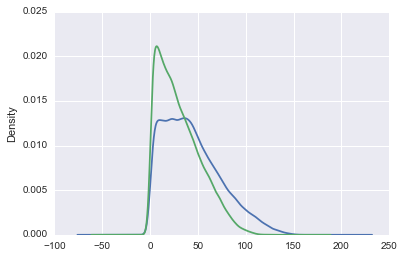

In [124]:
zi_data.spread.dropna().plot(kind='kde')
zic_data.spread.dropna().plot(kind='kde')
plt.show()

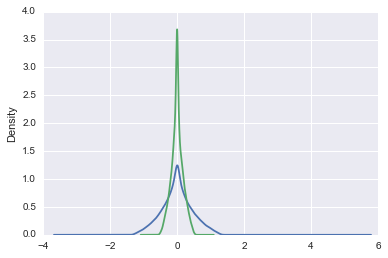

In [125]:
zi_data.log_returns.dropna().plot(kind='kde')
zic_data.log_returns.dropna().plot(kind='kde')
plt.show()

In [112]:
zi_data.log_returns.describe()

count    76651.000000
mean         0.000045
std          0.454915
min         -1.312186
25%         -0.276253
50%          0.000000
75%          0.272867
max          3.423176
Name: log_returns, dtype: float64

In [113]:
zic_data.log_returns.describe()

count    54661.000000
mean         0.000047
std          0.331568
min         -1.245937
25%         -0.155564
50%          0.000000
75%          0.158224
max          3.120895
Name: log_returns, dtype: float64

In [65]:
zic_data.price.describe()

count    412101.000000
mean         97.785936
std          15.034160
min          70.000000
25%          85.000000
50%          98.000000
75%         110.000000
max         140.000000
Name: price, dtype: float64